# Stat 535 HW2
Dongyang Wang

In [2]:
import pandas as pd
import numpy as np
import math
import random
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

%matplotlib inline

## Problem 1


Part A: Generate Simulation Data

In [3]:
random.seed(42)

In [23]:
K = list(np.arange(3,40,4))
K = [1] + K + [40]
n_test = 10000
n_train = 500
B = 30
K

[1, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 40]

In [5]:
p_binomial = 0.7
mean_normal_pos = [1.6, 0]
mean_normal_neg = [-1.6, 0]
normal_cov = [[1,0],[0,1]]

In [6]:
def gen_sim_data(sample = n_train):
    
    y = list(np.random.binomial(n = 1, p = 0.7, size = sample))
    for i in range(len(y)):
        if y[i] == 0:
            y[i] = -1
    x = []
    for i in range(sample):
        if y[i] == 1:
            x.append(list(np.random.multivariate_normal(mean = mean_normal_pos, cov = normal_cov)))
        else:
            x.append(list(np.random.multivariate_normal(mean = mean_normal_neg, cov = normal_cov)))
        x[i].append(y[i])
    return x

In [24]:
test_set = gen_sim_data(n_test)

The following functions calculate the Euclidean distance, obtain nearest neighbors, classify based on nearest neighbors, identify predictions on test data given training data, create training sets, and calculate the expected loss, respectively. 

In [8]:
def euclidean_dis(x1, x2):
    
    if len(x1) != len(x2):
        return "Error in length!"
    distance = math.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)
    return distance

def k_nearest(point, data, K_neighbors):
    
    distance = []
    for i in range(len(data)):
        dis = euclidean_dis(point, [data[i][0], data[i][1]])
        distance.append([data[i], dis])
    distance.sort(key=lambda d: d[1])
    
    neighbors = []
    for i in range(K_neighbors):
        neighbors.append(distance[i][0])
    return neighbors

def knn_classify(neighbors):
    avg = np.mean([neighbor[2] for neighbor in neighbors])
    if avg >= 0:
        return 1
    else:
        return -1

def knn(test, data, K_neighbors):
    
    points = [[i[0] , i[1]] for i in test]
    test = [i[0:3] for i in test]
    results = test[:]
    
    for i in range(len(points)):
        point = points[i]
        
        neighbors = k_nearest(point, data, K_neighbors)
        prediction = knn_classify(neighbors)
        results[i].append(prediction)
    
    return results

def gen_train_set(number = B):
    train = []
    for i in range(number):
        train.append(gen_sim_data(n_train))
    return train

def evaluate_accuracy(data):
    actual = [i[2] for i in data]
    pred = [i[3] for i in data]
    return sum([i[2] != i[3] for i in data])/len(data)

Part B

In [9]:
train_set = gen_train_set(30) 

The following function calculates the l_b and L_b together.

In [10]:
def expected_loss(test, train_set, B, K_neighbors):
    
    l_b = []
    L_b = []
    
    for i in range(B):
        train_one = train_set[i]
        
        temp_data1 = knn(train_one, train_one, K_neighbors)
        l_b.append(evaluate_accuracy(temp_data1))
        
        temp_data2 = knn(test, train_one, K_neighbors)
        L_b.append(evaluate_accuracy(temp_data2))
        
        
    return [l_b, L_b]

Part C

Calculate empirical variance

In [11]:
def calculate_V(test, train_set, B, K_neighbors):
    
    res = []
    
    for i in range(B):
        train_one = train_set[i]
        
        temp_data = knn(test, train_one, K_neighbors)
        res.append([j[3] for j in temp_data])
    
    p_i = []
    for i in range(len(res[0])):
        temp_sum = 0
        for j in range(B):
            temp_sum += res[j][i]
        p_i.append(temp_sum/(2*B) + 1/2)
    
    V = 0
    for i in p_i:
        V += i*(1-i)
        
    V = V/len(test)
    return V

Part D

In [12]:
def obtain_lb_avg(test, train_set, B, K_neighbors):
    results = expected_loss(test, train_set, B, K_neighbors)
    return np.mean(results[0]), np.mean(results[1])

Part E

In [13]:
def all_problem_1(K, test, train_set, B):
    
    lbs = []
    Vs = []
       
    for i in range(len(K)):
        K_neighbors = K[i]
        
        lbs.append(expected_loss(test, train_set, B, K_neighbors))
        Vs.append(calculate_V(test, train_set, B, K_neighbors))
        
    return lbs, Vs        

In [14]:
result = all_problem_1(K, test_set, train_set, B)

In [15]:
Vs = result[1]

In [16]:
def obtain_knn_results(result):
    
    avg_L = []
    sd_L = []
    avg_l = []
    sd_l = []
    
    for i in range(len(result[0])):
        avg_l.append(np.mean(result[0][i][0]))
        sd_l.append(np.std(result[0][i][0]))
        
        avg_L.append(np.mean(result[0][i][1]))
        sd_L.append(np.std(result[0][i][1]))
    return avg_l, sd_l, avg_L, sd_L

In [17]:
final_result = obtain_knn_results(result)

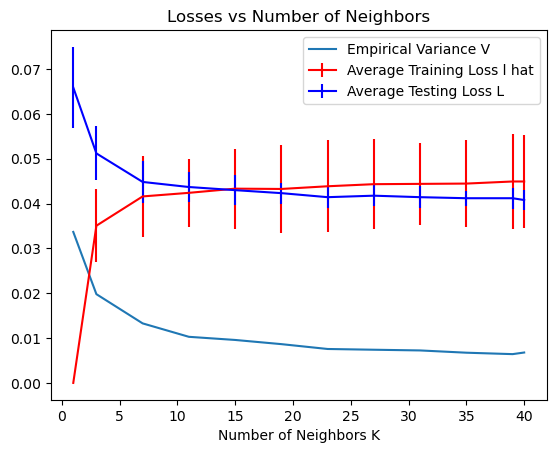

In [18]:
plt.errorbar(K,final_result[0], yerr = final_result[1],color = "red", label = "Average Training Loss l hat")
plt.errorbar(K,final_result[2], yerr = final_result[3],color = "blue", label = "Average Testing Loss L")
plt.plot(K,Vs, label = "Empirical Variance V")

plt.title("Losses vs Number of Neighbors")
plt.xlabel("Number of Neighbors K")
plt.legend()
plt.show()

Part F

The graph of the empirical variance shows the influence of K on the classifier variance. Basically, when the number of neighbors is very small, the variance tends to be big. It goes down as the number of neighbors increase, but eventually turns back up when K is equal to 30.

Part G

The loss graphs show the bias of the KNN classifier. As we can observe, testing loss is lowest (best) when number of neighbors is around 5-15. The variance of the bias will be low at the same time. Training loss is generally lower when the number of neighbors is small. The variance for training loss is overall constant.

Part H

$L_{01}^* = E_{P_X}(1 - max_yP(Y|X))$ where $P(Y = 1| X) = \frac{P(Y = 1) * P(X| Y = 1) }{P(Y = 1) * P(X| Y = 1)  + P(Y = 0) * P(X| Y = 0) }$  The pdf are all provided in the question, so I will not further detail them here. So the algorithm can be followed.

In [19]:
def bayes_loss(x):
    
    pos = multivariate_normal.pdf(x, mean = [1.6, 0], cov = [[1,0],[0,1]])
    neg = multivariate_normal.pdf(x, mean = [-1.6, 0], cov = [[1,0],[0,1]])
    score = pos*0.7/ (pos*0.7 + neg*0.3)
    return min(score, 1-score)

In [25]:
bayes_l = 0
for i in test_set:
    bayes_l += bayes_loss(i[0])
bayes_l = bayes_l/len(test_set)
bayes_l

0.0496181198661849

In [26]:
bayes_l = [bayes_l] *len(K)

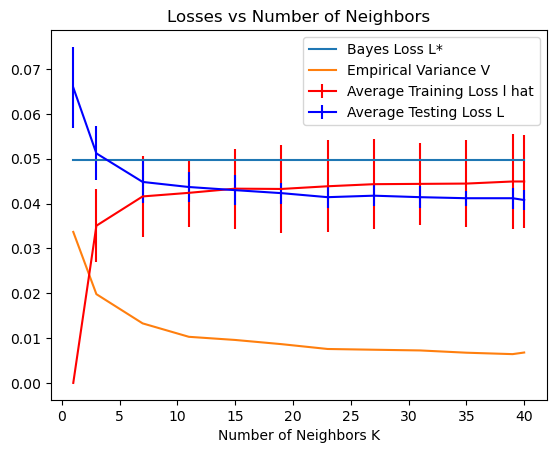

In [27]:
plt.errorbar(K,final_result[0], yerr = final_result[1],color = "red", label = "Average Training Loss l hat")
plt.errorbar(K,final_result[2], yerr = final_result[3],color = "blue", label = "Average Testing Loss L")
plt.plot(K,bayes_l, label = "Bayes Loss L*")
plt.plot(K,Vs, label = "Empirical Variance V")

plt.title("Losses vs Number of Neighbors")
plt.xlabel("Number of Neighbors K")
plt.legend()
plt.show()

## Problem 3

Part A

Solving the equation below,
 $\int_{-1}^1 \frac{\alpha}{3}\frac{1}{0.3\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x}{0.3}\right)^{\!2}\,\right) + \frac{4}{3} \frac{1}{0.6\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-1}{0.6}\right)^{\!2}\,\right) \;\mathrm{d}x = 1$

By obtaining the cdf of two component distributions at -1 and 1, we obtain that $\alpha = 2$

Part B

In [126]:
import requests

response = requests.get('https://sites.stat.washington.edu/mmp/courses/535/fall22/assignments/hw2-kr.dat')
hw2_kr = response.text

data_by_line = hw2_kr.split('\n')
data_by_line = data_by_line[:len(data_by_line)-1]

for i in range(0,len(data_by_line)):
    data_by_line[i] = ' '.join(data_by_line[i].split())
    data_by_line[i] = data_by_line[i].split(' ')

hw2_kr = [0] * len(data_by_line)
    
for i in range(len(data_by_line)):
    hw2_kr[i] = [float(j) for j in data_by_line[i]]

kr_data = pd.DataFrame(hw2_kr, columns =['x', 'f(x)'])

In [127]:
h = 0.1

In [128]:
def gaussian_density(x):
    if x >1 or x< -1:
        return 0
    
    part1 = 1/(math.sqrt(2*np.pi*0.3**2)) * np.exp(-x**2/(2*0.3**2))
    part2 = 1/(math.sqrt(2*np.pi*0.6**2)) * np.exp(-(x-1)**2/(2*0.6**2))
    return 2/3 * part1 + 4/3 * part2

In [129]:
def kernel_reg(point, data):
    
    res = 0
    weights = 0
    
    for i in range(len(data)):
        cur_point = data.iloc[i]
        
        if cur_point[0] >= point[0] - h or cur_point[0] <= point[0] + h:
            weight = gaussian_density(abs(data.iloc[i][0] - point[0])/h)
            weights += weight
            res += weight * data.iloc[i][1]
    
    return res/weights

In [130]:
def kernel_full(data):
    
    res = []
    
    for i in range(len(data)):
        
        point = data.iloc[i]
        res.append(kernel_reg(point, data))
    
    return res

In [131]:
yhat = kernel_full(kr_data)

In [132]:
kr_data['yhat'] = yhat

In [133]:
kr_data = kr_data.sort_values(by = "x")

In [134]:
kr_data

,x,f(x),yhat
74,-0.722107,1.521438,1.471140
209,-0.638217,1.407321,1.422826
219,-0.583313,1.340254,1.369072
130,-0.442269,1.195602,1.160935
252,-0.374001,1.139877,1.131330
...,...,...,...
129,0.989994,1.980088,1.914033
82,0.990637,1.981361,1.914019
141,0.993361,1.986766,1.917650
266,0.999056,1.998113,1.917155


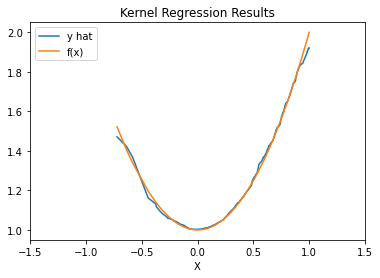

In [135]:
plt.plot(kr_data['x'], kr_data['yhat'], label = "y hat")
plt.plot(kr_data['x'], kr_data['f(x)'], label = "f(x)")

plt.title("Kernel Regression Results")
plt.xlabel("X")
plt.xlim(-1.5,1.5)
plt.legend()
plt.show()

Part C

In [136]:
kr_data["error"] = kr_data["f(x)"] - kr_data["yhat"]  

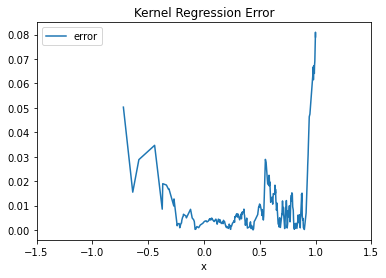

In [137]:
plt.plot(kr_data['x'], abs(kr_data['error']), label = "error")

plt.title("Kernel Regression Error")
plt.xlabel("x")
plt.xlim(-1.5,1.5)
plt.legend()
plt.show()

Part D

In [138]:
x_den = np.arange(-1,1,step = 0.01)
y_den = []
for i in x_den:
    y_den.append(gaussian_density(i))

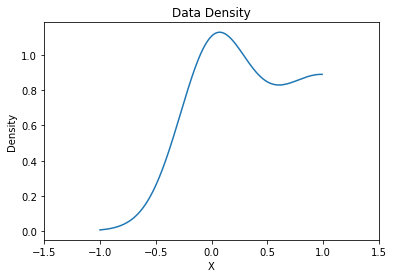

In [139]:
plt.plot(x_den, y_den)

plt.title("Data Density")
plt.xlabel("X")
plt.ylabel("Density")
plt.xlim(-1.5,1.5)
plt.show()

Part E

We have $f' = 2x$ and $f'' = 2$ and $p_x = \frac{2}{3} \frac{1}{0.3\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-0}{0.3}\right)^{\!2}\,\right) + \frac{4}{3} \frac{1}{0.6\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-1}{0.6}\right)^{\!2}\,\right)$ and $p_x' = \frac{2}{3} (-\frac{x}{0.3^2})  \frac{1}{0.3\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-0}{0.3}\right)^{\!2}\,\right) + \frac{4}{3} (-\frac{x-1}{0.6^2}) \frac{1}{0.6\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-1}{0.6}\right)^{\!2}\,\right)$ and $\frac{p_x'}{p_x} = \frac{\frac{2}{3} (-\frac{x}{0.3^2})  \frac{1}{0.3\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-0}{0.3}\right)^{\!2}\,\right) + \frac{4}{3} (-\frac{x-1}{0.6^2}) \frac{1}{0.6\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-1}{0.6}\right)^{\!2}\,\right)}{\frac{2}{3} \frac{1}{0.3\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-0}{0.3}\right)^{\!2}\,\right) + \frac{4}{3} \frac{1}{0.6\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-1}{0.6}\right)^{\!2}\,\right)}$

In [140]:
def px_ratio(x):
    part1 = 2/3 * 1/(0.3 * math.sqrt(2*np.pi)) * np.exp(-(x/0.3)**2/2)
    part2 = 4/3 * 1/(0.6 * math.sqrt(2*np.pi)) * np.exp(-((x-1)/0.6)**2/2)
    part1_updated = part1 * (-x/(0.3**2))
    part2_updated = part1 * (-(x-1)/(0.6**2))
    return (part1_updated + part2_updated)/(part1 + part2)

In [141]:
kr_data["f_prime"] = kr_data['x'] *2
kr_data["f_prime2"] = 2
kr_data["px_ratio"] = px_ratio(kr_data['x'])

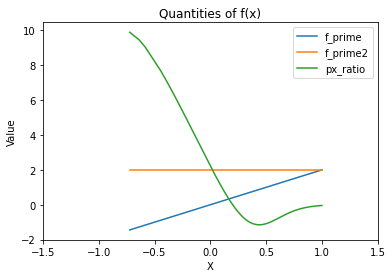

In [142]:
plt.plot(kr_data['x'], kr_data['f_prime'], label = "f_prime")
plt.plot(kr_data['x'], kr_data['f_prime2'], label = "f_prime2")
plt.plot(kr_data['x'], kr_data['px_ratio'], label = "px_ratio")

plt.title("Quantities of f(x)")
plt.xlabel("X")
plt.ylabel("Value")
plt.xlim(-1.5,1.5)
plt.legend()
plt.show()

Part F

In [143]:
kr_data["bias"] = kr_data['px_ratio']*kr_data['f_prime'] + kr_data['f_prime2']**2 

In [144]:
kr_data

,x,f(x),yhat,error,f_prime,f_prime2,px_ratio,bias
74,-0.722107,1.521438,1.471140,0.050298,-1.444214,2,9.892538,-10.286942
209,-0.638217,1.407321,1.422826,-0.015505,-1.276434,2,9.455863,-8.069785
219,-0.583313,1.340254,1.369072,-0.028818,-1.166626,2,9.038821,-6.544924
130,-0.442269,1.195602,1.160935,0.034667,-0.884538,2,7.657645,-2.773478
252,-0.374001,1.139877,1.131330,0.008547,-0.748002,2,6.884300,-1.149470
...,...,...,...,...,...,...,...,...
129,0.989994,1.980088,1.914033,0.066055,1.979988,2,-0.047182,3.906580
82,0.990637,1.981361,1.914019,0.067342,1.981274,2,-0.046888,3.907102
141,0.993361,1.986766,1.917650,0.069116,1.986722,2,-0.045661,3.909284
266,0.999056,1.998113,1.917155,0.080958,1.998112,2,-0.043187,3.913707


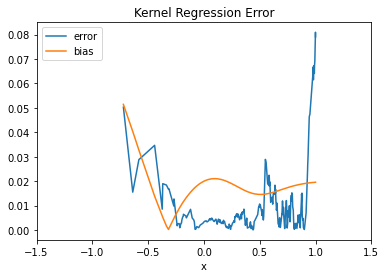

In [145]:
plt.plot(kr_data['x'], abs(kr_data['error']), label = "error")
plt.plot(kr_data['x'], abs(kr_data['bias']*0.005), label = "bias")

plt.title("Kernel Regression Error")
plt.xlabel("x")
plt.xlim(-1.5,1.5)
plt.legend()
plt.show()

The graphs are similar except that the bias is smoother on the upper end where x is near 1.

(array([ 3.,  1., 15., 16., 30., 40., 39., 47., 53., 56.]),
 array([-0.722107 , -0.5499151, -0.3777232, -0.2055313, -0.0333394,
         0.1388525,  0.3110444,  0.4832363,  0.6554282,  0.8276201,
         0.999812 ]),
 <BarContainer object of 10 artists>)

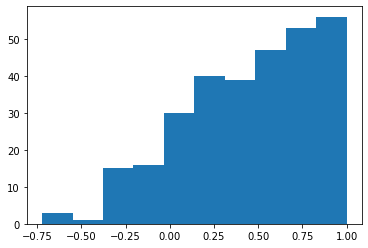

In [146]:
plt.hist(kr_data['x'])

Part G

Yes, there are border effects at x = +1 and x = -1. For one thing, there are very few observations near x = -1. This makes the small bandwidth 0.1 cover only a small number of points, which can easily lead to higher bias. On the other hand, at x = 1, since there are no other points to the right, the predictions of the Gaussian kernel tends to be a little smaller since within the bandwidth there are quite a few points that take weights but they generally contain smaller y values as compared with points to the very right end of the distribution.

Part H

The bias observed at x = 0 is exactly 4 due to the calculation that the first derivative of f will be 0 and the bias is determined solely by the second derivative. It appears as a local maximum in our case.

## Problem 4

Part A

$P(Y = 1| X) = \frac{P(Y = 1) * P(X| Y = 1) }{P(Y = 1) * P(X| Y = 1)  + P(Y = 0) * P(X| Y = 0) } 
= \frac{\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right)} {\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) + \frac{2}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)}$

Part B

The following is the Bayes Classifier

$f^*(x) = 1$ if $P(Y = 1| X) > P(Y = 0| X)$ and $f^*(x) = -1$ otherwise. $P(Y = 1| X) > P(Y = 0| X)$  can also be written as $\frac{1}{3}  \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) > \frac{2}{3} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)$

The following is the Bayes Loss

$L_{01}^* = E_{P_X}(1 - max_yP(Y|X))$ where $P(Y = 1| X) = \frac{\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right)} {\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) + \frac{2}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)}$ and $P(Y = 0| X) =1 - \frac{\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right)} {\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) + \frac{2}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)}$

For the numerical integration of L*

In [147]:
import requests

response = requests.get('https://sites.stat.washington.edu/mmp/courses/535/fall22/assignments/hw2-1d-train.dat')
hw2_1d = response.text

data_by_line = hw2_1d.split('\n')
data_by_line = data_by_line[:len(data_by_line)-1]

for i in range(0,len(data_by_line)):
    data_by_line[i] = ' '.join(data_by_line[i].split())
    data_by_line[i] = data_by_line[i].split(' ')

hw2_1d = [0] * len(data_by_line)
    
for i in range(len(data_by_line)):
    hw2_1d[i] = [float(j) for j in data_by_line[i]]

d_data = pd.DataFrame(hw2_kr, columns =['x', 'y'])

In [148]:
def bayes_loss1(x):
    
    pos = scipy.stats.norm(2, 1).pdf(x)
    neg = scipy.stats.norm(-1.2, 1).pdf(x)
    score = 1/3 * pos / (pos*1/3 + neg*2/3)
    return min(score, 1-score)

In [149]:
b_loss = 0
for i in d_data["x"]:
    b_loss += bayes_loss1(i)
b_loss = b_loss/len(d_data["x"])

In [150]:
b_loss

0.2890278466236203

As for $\theta^*$, we derive it by setting $P(Y = 1| X) = P(Y = 0| X)$, that is solving $\frac{1}{3}  \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) = \frac{2}{3} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)$ and we get $ - \frac{1}{2} (x^2 - 4x + 4) = \log2 - \frac{1}{2} (x^2 + 2.4x + 1.44)$ and by calculation, we obtain $\theta^* = 0.689$.

Part C

In [151]:
def normal_pos(x):
  return 1/3 * 1/(math.sqrt(2*np.pi)) * np.exp(-(x-2)**2/2)

def normal_neg(x):
  return 2/3 * 1/(math.sqrt(2*np.pi)) * np.exp(-(x+1.2)**2/2)

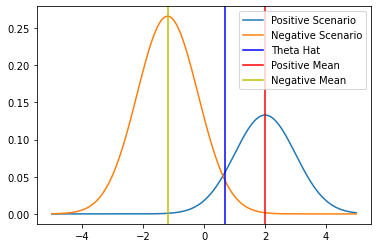

In [152]:
x_q4 = np.arange(-5,5,step = 0.01)
y_pos = []
y_neg = []
for i in x_q4:
    y_pos.append(normal_pos(i))
    y_neg.append(normal_neg(i))

plt.plot(x_q4, y_pos, label = 'Positive Scenario')
plt.plot(x_q4, y_neg, label = 'Negative Scenario')
plt.axvline(x = 0.689, color = 'b', label = 'Theta Hat')
plt.axvline(x = 2, color = 'r', label = 'Positive Mean')
plt.axvline(x = -1.2, color = 'y', label = 'Negative Mean')
plt.legend()

Part D

With given form of $P(Y=1|X)$ we can set $
= \frac{\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right)} {\frac{1}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-2}{1}\right)^{\!2}\,\right) + \frac{2}{3} \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x+1.2}{1}\right)^{\!2}\,\right)} = \frac{1}{1+\exp(ax-b)}$ After simplification, we obtain $\exp(-\frac{1}{2}(x- 2)^2 + ax +b) = 2\exp(-\frac{1}{2} (x+1.2)^2)$. Solving this, we have $a = -2.72$ and $b = \log2+0.8$
